In [1]:
import pandas as pd

from qiime2 import Artifact

import seaborn as sns

import skbio
from skbio.stats.distance import MissingIDError
from skbio import DistanceMatrix

import numpy as np
import scipy

from matplotlib import pyplot as plt
%matplotlib inline

import qiime2 as q2

In [2]:
#Convert vector to dataframe
vector_df = pd.read_csv('core-metrics-10000/shannon_vector.tsv', sep='\t', dtype=str).set_index('Unnamed: 0')

In [3]:
#Read metadata into pandas 
md = q2.Metadata.load('filtered-metadata.qza').to_dataframe()

In [4]:
#convert string values to integers
vector_df['shannon'] = pd.to_numeric(vector_df['shannon'])

In [5]:
#create an array of shannon differences in shannon values
shannon_ar = vector_df['shannon'].values - vector_df['shannon'].values[:, None]

In [6]:
#create dm from array
list_of_ids = list(vector_df.index.values)
dm_from_np = skbio.stats.distance.DissimilarityMatrix(shannon_ar, list_of_ids)

In [7]:
#Sync metadata to distance matrix

#remove samples in distance matrix that are not in metadata
dm_from_np = dm_from_np.filter(set(md.index) & set(dm_from_np.ids))

#remove samples in metadata that are not in distance matrix
md = md.loc[list(dm_from_np.ids)]

In [8]:
class MyDM(skbio.stats.distance.DissimilarityMatrix):
    def _stable_order(self, ids):

        id_order = sorted(self._id_index[i] for i in ids)
        return np.array(id_order, dtype=int)
    
    def between(self, from_, to_, allow_overlap=False):

        from_ = set(from_)
        to_ = set(to_)

        all_ids = from_ | to_
        not_present = all_ids - set(self._id_index)
        if not_present:
            raise MissingIDError("At least one ID (e.g., '%s') was not "
                                 "found." % not_present.pop())

        overlapping = from_ & to_
        if not allow_overlap and overlapping:
            raise KeyError("At least one ID overlaps in from_ and to_ "
                           "(e.g., '%s'). This constraint can removed with "
                           "allow_overlap=True." % overlapping.pop())

        return self._subset_to_dataframe(from_, to_)
    
    def _subset_to_dataframe(self, i_ids, j_ids):

        i_indices = self._stable_order(i_ids)
        j_indices = self._stable_order(j_ids)

        j_length = len(j_indices)
        j_labels = tuple([self.ids[j] for j in j_indices])

        i = []
        j = []

        values = [np.array([])]
        for i_idx in i_indices:
            i.extend([self.ids[i_idx]] * j_length)
            j.extend(j_labels)

            subset = self._data[i_idx, j_indices]
            values.append(subset)

        i = pd.Series(i, name='i')
        j = pd.Series(j, name='j')
        values = pd.Series(np.hstack(values), name='Shannon Difference')

        return pd.concat([i, j, values], axis=1)

In [9]:
def gather_between_distances(a_dm, a_md, fresh_baseline):
    pleasant_dm = MyDM(a_dm)

    tidy_data = []
    
    categories = ['sample_preservation_method', 'sample_storage_temp_treatment_week_added',
                  'duration_of_storage']
    
    if fresh_baseline:
        baseline_ids = {}
        for hid, grp in md.groupby('host_subject_id'):
            only_fresh = grp[grp['duration_of_storage'] == 'fresh']
            for preservative, pres_grp in only_fresh.groupby('sample_preservation_method'):
                baseline_ids[(hid, preservative)] = pres_grp.index
        
    else:
        baseline_ids = {}
        for hid, grp in a_md.groupby('host_subject_id'):
            host_baseline = []
            for index, row in grp[categories].iterrows():
                if (row == ['None', 'amb', 'fresh']).all():
                    host_baseline.append(index)
            baseline_ids[hid] = host_baseline
    
    for (pres, temp, dur, hid), grp in a_md.groupby(categories + ['host_subject_id']):   
        if fresh_baseline:
            if (hid,pres) in baseline_ids:
                base_ids = baseline_ids[hid,pres]
                
                distances = pleasant_dm.between(base_ids, grp.index, allow_overlap=True)
                distances['sample_preservation_method'] = pres
                distances['sample_storage_temp_treatment_week_added'] = temp
                distances['duration_of_storage'] = dur

                tidy_data.append(distances)
        else:
            base_ids = baseline_ids[hid]
            
            distances = pleasant_dm.between(base_ids, grp.index, allow_overlap=True)

            distances['sample_preservation_method'] = pres
            distances['sample_storage_temp_treatment_week_added'] = temp
            distances['duration_of_storage'] = dur

            tidy_data.append(distances)

    tidy_data = pd.concat(tidy_data)
    
    return tidy_data[tidy_data['i'] != tidy_data['j']]

In [10]:
def fancy_plotting(df):
    g = sns.catplot(data=df, x='duration_of_storage', y='Shannon Difference', 
                    hue='sample_storage_temp_treatment_week_added', col='sample_preservation_method',
                    kind='box', col_wrap=3,
                    #palette=sns.color_palette("RdBu_r", 7),
                    order=['1week', '4weeks', '8weeks'])
    
    g.set_axis_labels("Duration of Storage", "Shannon Difference")
    g.set_xticklabels(["1 week", "4 weeks", "8 weeks"])
    g.set_titles("{col_name}")
    g._legend.set_title("Temperature Treatment")
    
    new_labels = ['−20C', '−20C after one week','4C','Ambient','Freeze-thaw','Heat']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    
    for ax in g.axes.flat:
        ax.set_title(ax.get_title(), fontsize='xx-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
        ax.axhline(0, ls='-', color='black', linewidth=2)
        
    return g

In [11]:
between_distances = gather_between_distances(dm_from_np, md, True)

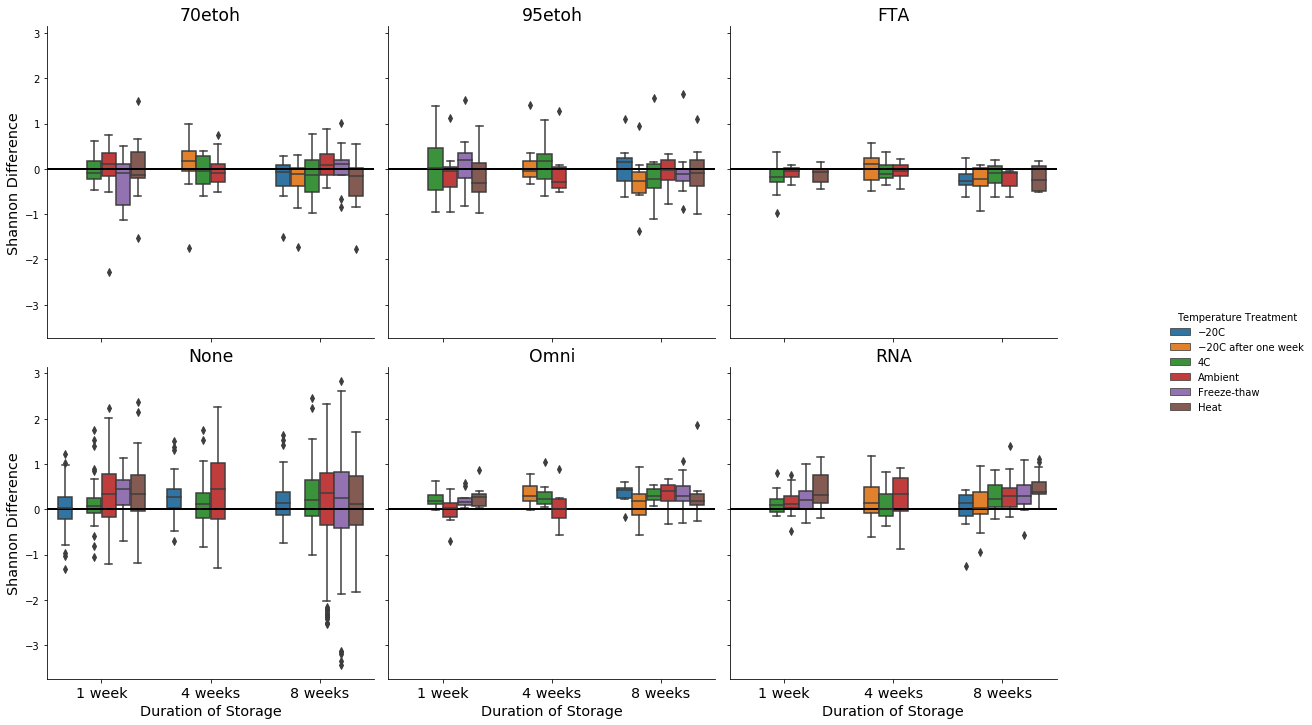

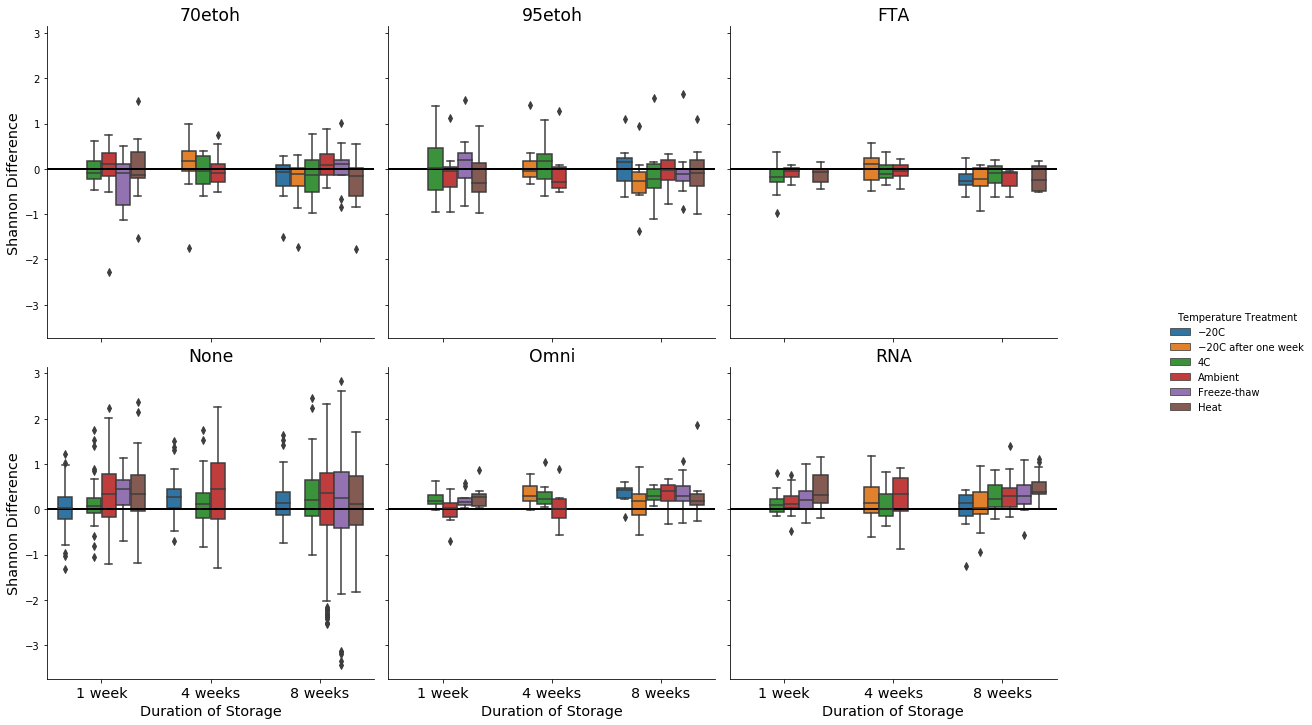

In [12]:
fancy_plotting(between_distances).savefig('shannon-difference-fresh-bl.png')
fancy_plotting(between_distances).savefig('shannon-figure-fresh-amb-bl.svg', format='svg', dpi=1200)

In [13]:
def fancy_plotting2(df):
    g = sns.catplot(data=df, x='duration_of_storage', y='Shannon Difference', 
                    hue='sample_storage_temp_treatment_week_added', col='sample_preservation_method',
                    kind='box', col_wrap=3,
                    #palette=sns.color_palette("RdBu_r", 7),
                    order=['fresh','1week', '4weeks', '8weeks'])
    
    g.set_axis_labels("Duration of Storage", "Shannon Difference")
    g.set_xticklabels(["Fresh", "1 week", "4 weeks", "8 weeks"])
    g.set_titles("{col_name}")
    g._legend.set_title("Temperature Treatment")
    
    new_labels = ['−20C', '−20C after one week','4C','Ambient','Freeze-thaw','Heat']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    
    for ax in g.axes.flat:
        ax.set_title(ax.get_title(), fontsize='xx-large')
        ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
        ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
        ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-large')
        ax.axhline(0, ls='-', color='black', linewidth=2)
    
    return g

In [14]:
between_distances2 = gather_between_distances(dm_from_np, md, False)

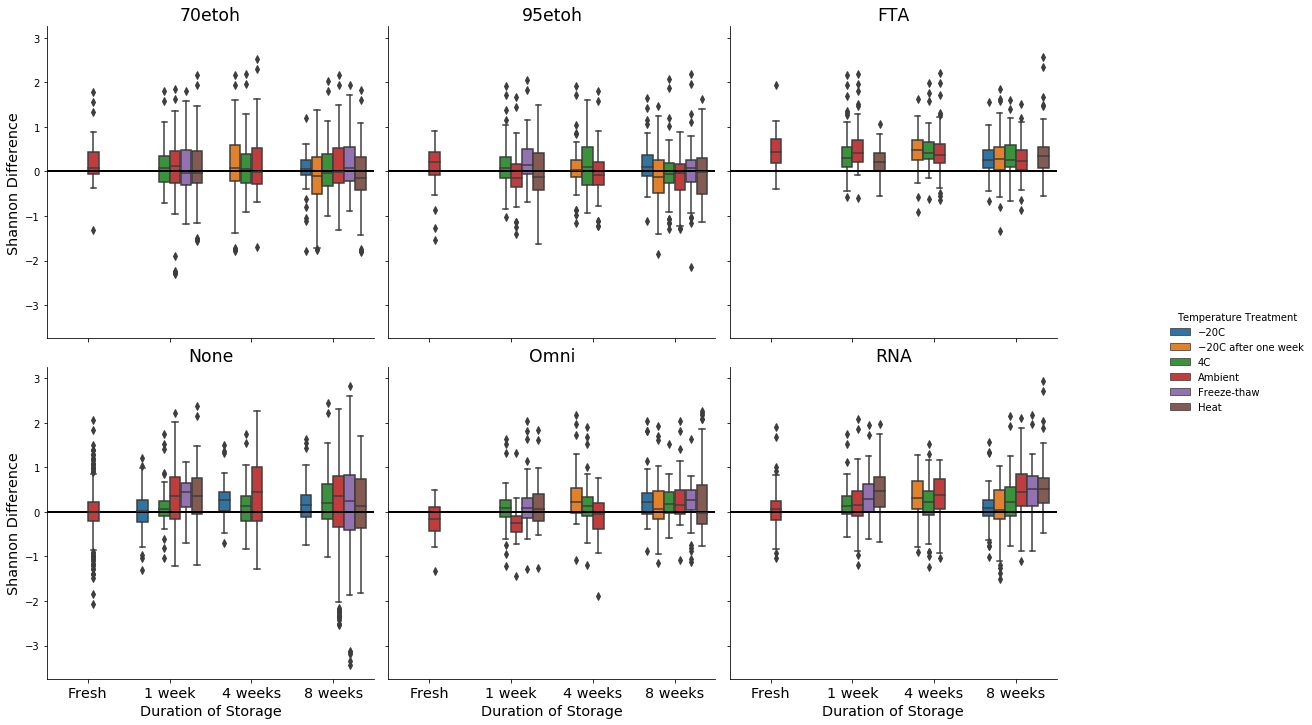

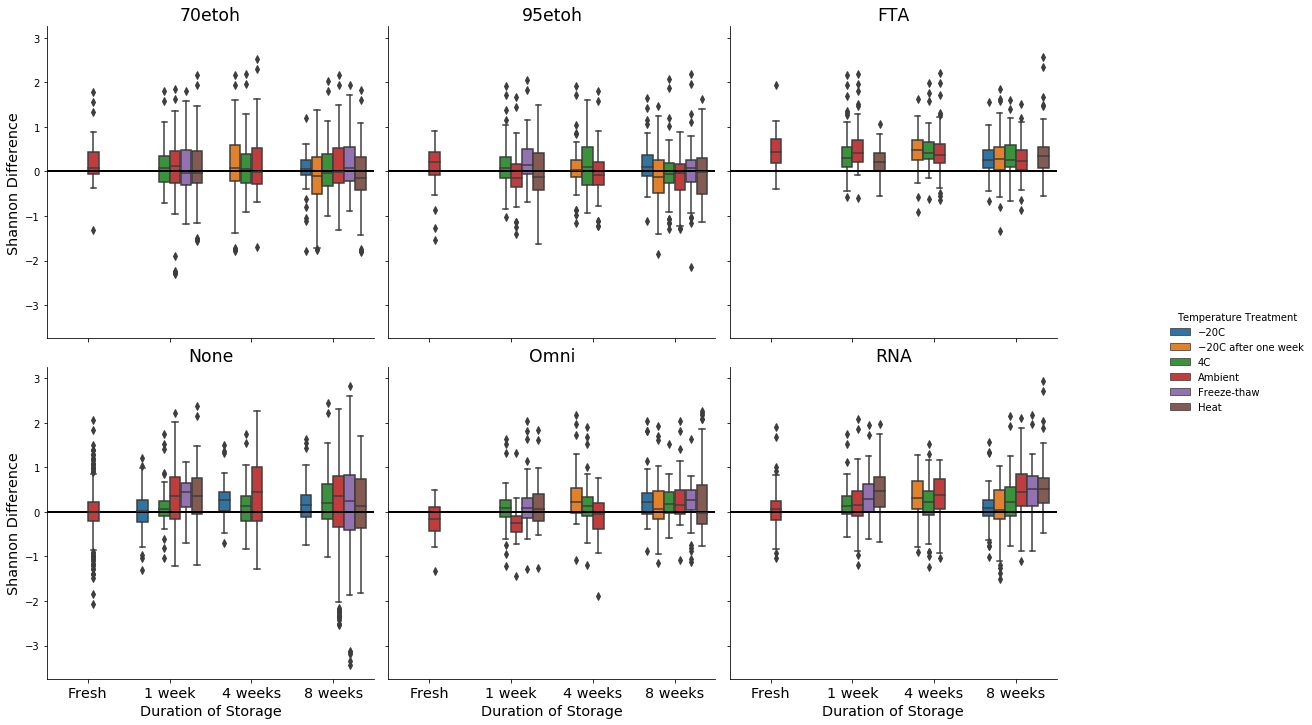

In [15]:
fancy_plotting2(between_distances2).savefig('shannon-difference-none-fresh-amb-bl.png')
fancy_plotting2(between_distances2).savefig('shannon-figure-none-fresh-amb-bl.svg', format='svg', dpi=1200)